# IQTREE Stats Notebook

## 0. **Setup**

## 1. **Import**

## 2. **Root-To-Tip Regression**  

- Calculate Clade And Root Distances


## 3. **Isolation By Distance**  

## 4. **Timeline**


---
# 0. SETUP

## Modules

In [1]:
import os
import pandas as pd
import geopandas
import shapely
import matplotlib.pyplot as plt
from matplotlib import colors,lines
import cartopy.crs as ccrs
import scipy
import datetime
from Bio import AlignIO, Phylo
import seaborn as sns
import subprocess
import geopy
from geopy import distance
import statsmodels.formula.api as smfa
import statsmodels.stats.multitest as smmt
import math
from skbio.stats import distance as skbio_dist
from functions import *

## Paths

In [2]:
try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "full", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
      
results_dir = os.path.join(project_dir, "results/")

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [3]:
iqtree_dir    = os.path.join(results_dir, "iqtree/all/chromosome/{}/filter{}/".format(PRUNE, MISSING_DATA))


metadata_path = iqtree_dir    + "filter-taxa/metadata.tsv"
# ------------------------------------------
# Trees
divtree_path  = iqtree_dir    + "filter-taxa/iqtree.treefile"

if PRUNE == "prune":
    full_divtree_path = divtree_path.replace("prune","full")
    full_metadata_path = metadata_path.replace("prune","full")
else:
    full_divtree_path = divtree_path
    full_metadata_path = metadata_path

# ------------------------------------------
# Alignment
constant_sites_path   = results_dir + "snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt"
aln_path              = iqtree_dir + "filter-sites/snippy-multi.snps.aln"

# ------------------------------------------
# Output
out_dir = iqtree_dir    + "filter-taxa/"
if not os.path.exists(out_dir):
    subprocess.run(["mkdir", "-p", out_dir]) 

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"
UNKNOWN_CHAR = "?"
CONFIDENCE = 95
ALPHA = 0.05

# ------------------------------------------
# Time
CURRENT_YEAR = datetime.datetime.utcnow().year

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

# ------------------------------------------
# Plotting
SM_FONT = 4
MED_FONT = 6
LG_FONT = 8
D3_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf" ]
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.dpi']=400

# ------------------------------------------
BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"],   
    # Exclude ancient  0.PE8, 
    "0.PE": ["0.PE2", "0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5", "0.PE7", "0.PE10"],      
    #"0.PE": ["0.PE2", "0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5", "0.PE7", "0.PE8", "0.PE10"],  
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],
    #"0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT4","0.ANT5"], 
    "0.ANT4" : ["0.ANT4"],     
    "1.PRE" : ["1.PRE0", "1.PRE1", "1.PRE2", "1.PRE3"],    
    "1.ANT": ["1.ANT1"], 
    "1.IN": ["1.IN1","1.IN2","1.IN3"],   
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ], 
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ], 
    "3.ANT": ["3.ANT1", "3.ANT2" ],     
    "4.ANT": ["4.ANT1" ],           
}

ANCIENT_BRANCH_LIST = {
    "0.PRE": ["0.PRE1", "0.PRE2"], 
    "0.ANT4" : ["0.ANT4"],  
    "1.PRE" : ["1.PRE1", "1.PRE2", "1.PRE3"],     
}

MUG_ATTRIBUTE_LIST = [
    "branch_major",
    "branch_minor",
    "country",
    "province",
]

---
# 1. IMPORT

## Trees

In [5]:
divtree = Phylo.read(divtree_path, "newick")
divtree.ladderize(reverse=False)

full_divtree = Phylo.read(full_divtree_path, "newick")
full_divtree.ladderize(reverse=False)

## Metadata

In [6]:
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col = 0)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

full_metadata_df = pd.read_csv(full_metadata_path, sep='\t', index_col = 0)
full_metadata_df.fillna(NO_DATA_CHAR, inplace=True)

## Colors

In [7]:
colors_dict = {}

# Colors dictionary is based off full tree
for t in full_divtree.get_terminals():
    branch = full_metadata_df["branch_major"][t.name]
    if branch not in colors_dict and branch != NO_DATA_CHAR:
        colors_dict[branch] = ""

# Create the custom color map (pyplot)
cmap = plt.get_cmap("rainbow", len(colors_dict))
# Convert the color map to a list of RGB values
cmaplist = [cmap(i) for i in range(cmap.N)]
# Convert RGB values to hex colors
attr_hex = [colors.to_hex(col) for col in cmaplist]

# Assign colors to value
for branch, color in zip(colors_dict, attr_hex):
    colors_dict[branch] = color

print(colors_dict)


# Branch Major Clor
metadata_df["branch_major_color"] = [NO_DATA_CHAR] * len(metadata_df)

for c in divtree.get_terminals():
    sample = c.name
    # Clade Color  
    branch_major = metadata_df["branch_major"][sample]
    branch_major_color = colors_dict[branch_major]
    metadata_df.at[sample, "branch_major_color"] = branch_major_color

display(metadata_df)

{'0.PRE': '#8000ff', '0.PE': '#4c4ffc', '0.ANT': '#1996f3', '3.ANT': '#1acee3', '4.ANT': '#4df3ce', '2.ANT': '#80ffb4', '2.MED': '#b3f396', '1.PRE': '#e6ce74', '1.ANT': '#ff964f', '1.IN': '#ff4f28', '1.ORI': '#ff0000'}


,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,branch_major_color,geometry_size,geometry,root_rtt_dist,clade_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,#ff0000,1.0,POINT (-105.607716 38.7251776),0.000073,0.000006
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,#b3f396,4.0,POINT (40.7957942 47.6222451),0.000073,0.000010
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46334640000001 42.4804953),0.000054,0.000012
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46334640000001 42.4804953),0.000055,0.000012
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46334640000001 42.4804953),0.000055,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,#e6ce74,4.0,POINT (40.7957942 47.6222451),0.000075,0.000022
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,#e6ce74,1.0,POINT (18.1099 54.24556),0.000060,0.000007
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,#e6ce74,3.0,POINT (25.24953400167952 54.82269205),0.000060,0.000006


## Convert Dataframe to Geopandas

In [8]:
geometry = []
geometry_size_dict = {
    
}

# Create geometry size dict
for rec in metadata_df.iterrows():
    sample = rec[0]
    geo_name = rec[1]["province"]
    if geo_name == NO_DATA_CHAR:
        geo_name = rec[1]["country"]
    if geo_name not in geometry_size_dict:
        geometry_size_dict[geo_name] = 0
    geometry_size_dict[geo_name] += 1

# Add geometry size column
for rec in metadata_df.iterrows():   
    geo_name = rec[1]["province"]
    lat = rec[1]["province_lat"]
    lon = rec[1]["province_lon"]    
    if geo_name == NO_DATA_CHAR:
        geo_name = rec[1]["country"]
        lat = rec[1]["province_lat"]
        lon = rec[1]["province_lon"]      
        
    lat = rec[1]["lat"]
    lon = rec[1]["lon"]
    point = shapely.geometry.Point(lon,lat)
    size = geometry_size_dict[geo_name]
    metadata_df.at[rec[0],"geometry_size"] = size
    geometry.append(point)
    
metadata_gdf = geopandas.GeoDataFrame(metadata_df, crs="epsg:3857", geometry=geometry)

display(metadata_gdf)


# Generate a figure with two axes, one for CartoPy, one for GeoPandas
#fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
#                        figsize=(10, 5))
#world_polygons.plot(ax=ax, color="grey", alpha=0.5)
#metadata_gdf.plot(ax=ax, c="red", markersize="geometry_size", ec="black", lw=0.25)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,branch_major_color,geometry_size,geometry,root_rtt_dist,clade_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,#ff0000,1.0,POINT (-105.60772 38.72518),0.000073,0.000006
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,#b3f396,4.0,POINT (40.79579 47.62225),0.000073,0.000010
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46335 42.48050),0.000054,0.000012
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46335 42.48050),0.000055,0.000012
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46335 42.48050),0.000055,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,#e6ce74,4.0,POINT (40.79579 47.62225),0.000075,0.000022
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,#e6ce74,1.0,POINT (18.10990 54.24556),0.000060,0.000007
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,#e6ce74,3.0,POINT (25.24953 54.82269),0.000060,0.000006


---

# 1. Mapping

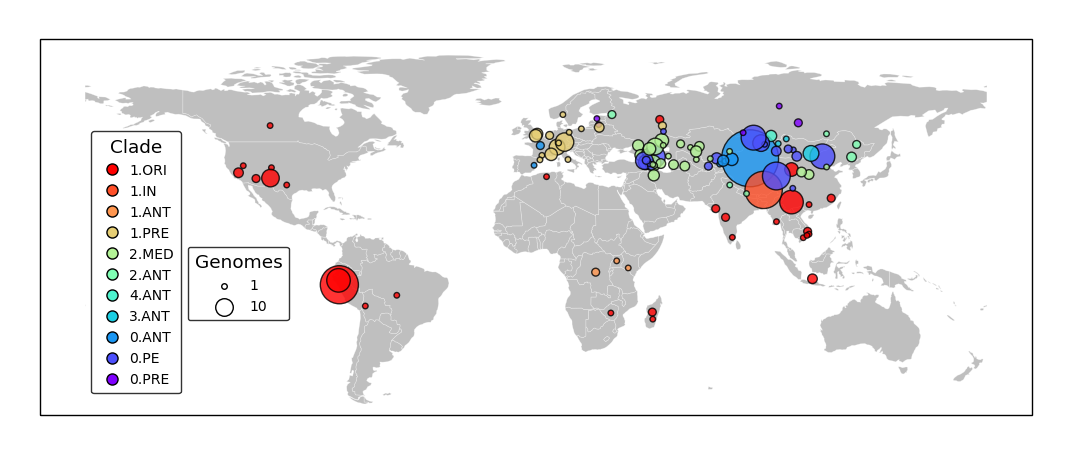

In [9]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5

## All
fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},
                        figsize=FIGSIZE, dpi=DPI)

for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)

# Sorry Antarctica
ax.set_ylim(-60,90)

world_polygons.plot(
    ax=ax, 
    zorder=1, 
    alpha=0.5, 
    color="grey",
    edgecolor="white", 
    linewidth=0.1,
) 
""
reduce_gdf = copy.deepcopy(metadata_gdf)

plotted_coord = []

for rec in metadata_gdf.iterrows():
    sample=rec[0]
    x,y = rec[1]["geometry"].x, rec[1]["geometry"].y
    if [x,y] not in plotted_coord:
        plotted_coord.append([x,y])
    else:
        reduce_gdf.drop(sample, inplace=True)

reduce_gdf.plot(
    ax=ax, 
    ec="black", 
    color=reduce_gdf["branch_major_color"], 
    markersize=reduce_gdf["geometry_size"], 
    linewidth=0.25,
    alpha=0.80,
)

# Clade legend
clades = list(colors_dict.keys())
clades.reverse()


clade_lines = [lines.Line2D([0], [0], color=colors_dict[clade], lw=0, markersize=2, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for clade in clades]
clade_labels = [clade for clade in clades]

clade_legend = fig.legend(clade_lines, 
           clade_labels,
           #ncol=len(clade_labels),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.2, 0.475),
           frameon=True,
            borderpad=0.5, 
            handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Clade",
           fontsize=FONTSIZE / 2,
           title_fontsize=FONTSIZE / 1.5,
          )
clade_legend.get_frame().set_linewidth(0.25)

# Size Legend
s = [ax.scatter(0,-9000, s=1, ec="black", c="white", lw=0.25),
     ax.scatter(0,-9000, s=10, ec="black", c="white", lw=0.25),  
    ]
sl = ["1", "10"]
leg_size = plt.legend(s, sl, title="Genomes", loc="center",  borderpad=0.5, bbox_to_anchor=[0.2,0.35], edgecolor="black",
                    fontsize=FONTSIZE / 2, title_fontsize=FONTSIZE / 1.5)
leg_size.get_frame().set_linewidth(0.25)

out_path = os.path.join(out_dir, "map_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---
# 2. RTT (Root-To-Tip Regression)

## Calculate Clade And Root Distances

In [10]:
metadata_df["root_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["clade_rtt_dist"] = [NO_DATA_CHAR] * len(metadata_df)

branch_mrca_dict = {}

for c in divtree.get_terminals():
    sample = c.name    
    # Clade MRCA Dist    
    branch_major = metadata_df["branch_major"][sample]
    if branch_major in branch_mrca_dict: continue

    branch_df = metadata_df[metadata_df["branch_major"] == branch_major]
    branch_tips = list(branch_df.index)
    branch_mrca = divtree.common_ancestor(branch_tips)
    branch_mrca_dict[branch_major] = branch_mrca

for c in divtree.get_terminals():
    sample = c.name
    # Root Dist
    root_dist = divtree.distance(divtree.root, c)

    # Clade MRCA Dist    
    branch_major = metadata_df["branch_major"][sample]

    branch_mrca = branch_mrca_dict[branch_major]
    branch_mrca_dist = divtree.distance(branch_mrca, c)

    metadata_df.at[sample, "root_rtt_dist"] = float(root_dist)
    metadata_df.at[sample, "clade_rtt_dist"] = float(branch_mrca_dist)

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,branch_major_color,geometry_size,geometry,root_rtt_dist,clade_rtt_dist
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,#ff0000,1.0,POINT (-105.60772 38.72518),7.31686e-05,6.3815e-06
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,#b3f396,4.0,POINT (40.79579 47.62225),7.30501e-05,9.6582e-06
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46335 42.48050),5.41847e-05,1.15566e-05
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46335 42.48050),5.47035e-05,1.20754e-05
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,#1996f3,105.0,POINT (85.46335 42.48050),5.4939e-05,1.23109e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,#e6ce74,4.0,POINT (40.79579 47.62225),7.54024e-05,2.21397e-05
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,#e6ce74,1.0,POINT (18.10990 54.24556),6.01348e-05,6.8721e-06
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,#e6ce74,3.0,POINT (25.24953 54.82269),5.95981e-05,6.3354e-06


## Report Average RTT by Clade

In [11]:
rtt_all_list = list(metadata_df["root_rtt_dist"])
rtt_all_mean = sum(rtt_all_list) / len(rtt_all_list)
rtt_dist_dict = {"All": rtt_all_mean}

for clade in BRANCH_LIST:
    df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[clade])])
    rtt_clade_list = list(df["clade_rtt_dist"])
    rtt_clade_mean = sum(rtt_clade_list) / len(rtt_clade_list)
    
    rtt_dist_dict[clade] = rtt_clade_mean
    
print(rtt_dist_dict)

{'All': 6.913333028286183e-05, '0.PRE': 3.848804999999999e-05, '0.PE': 7.750065301204819e-05, '0.ANT': 1.3128180582524258e-05, '0.ANT4': 1.6644416666666666e-05, '1.PRE': 1.1384555000000001e-05, '1.ANT': 1.35333e-05, '1.IN': 4.453964102564105e-06, '1.ORI': 5.959430769230769e-06, '2.ANT': 6.774798148148145e-06, '2.MED': 1.4159980172413794e-05, '3.ANT': 6.2694e-06, '4.ANT': 5.72540909090909e-06}


## RTT Distributions

Branch: 0.PRE
Branch: 0.PE
Branch: 0.ANT
Branch: 0.ANT4
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


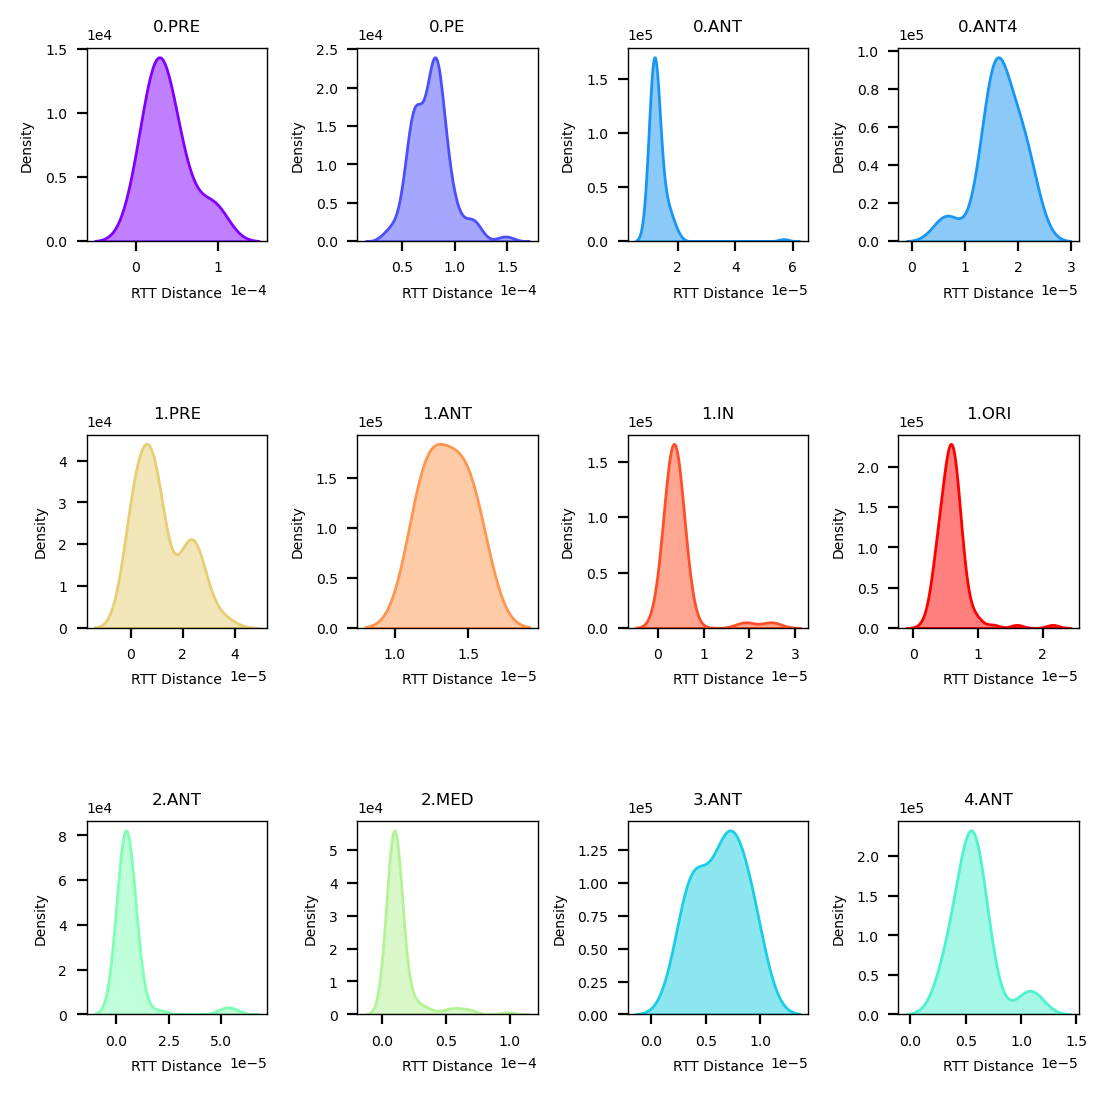

In [12]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280,  1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "clade_rtt_dist"
#reg_y = "root_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.50, hspace=1)

i_row = 0
i_col = 0

for clade in BRANCH_LIST:
    print("Branch:", clade)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]
    
    # Format axis
    ax.set_title(clade)

    if i_col == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("RTT Distance")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    #ax.set_xlim(0,2e-4)
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
        
    # Plot
    df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[clade])])
    
    dists = [float(d) for d in df["clade_rtt_dist"]]
    color = df["branch_major_color"][0]

    sns.kdeplot(
        ax=ax,
        x=dists,
        fill=True,
        zorder=1,
        color=color, 
        alpha=0.5,
        thresh=0.05,        
    )
  

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
        
out_path = os.path.join(out_dir, "rtt_dist_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")  

## B. Root-To-Tip Regression With Bootstrapping

## All

In [13]:
np.random.seed(5435455)
NBOOTS = 1000

bootstrap_mega_dict = {}

import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import linregress_bootstrap

# ALL
df = copy.deepcopy(metadata_df[(metadata_df["date_mean"] != NO_DATA_CHAR)])
label = "All"
print("Branch:", label)
color = "grey"
x = list(float(n) for n in df["date_mean"])
y = list(df["root_rtt_dist"])
xerr=list(df["date_err"])

bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=False, color=color, label=label)
bootstrap_mega_dict["All"] = bootstraps
bootstrap_mega_dict["All"]["samples"] = list(df.index)
bootstrap_mega_dict["All"]["color"] = "#c4c4c4"
bootstrap_mega_dict["All"]["xerr"] = xerr

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Branch: All


## Clade

In [14]:
for label in BRANCH_LIST:
    #if label != "1.ORI": continue
    print("Branch:", label)
    df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])])
    color = df["branch_major_color"][0]
    x = list(df["date_mean"])
    y = list(df["clade_rtt_dist"])
    #y = list(df["root_rtt_dist"])
    xerr=list(df["date_err"])

    bootstraps = linregress_bootstrap(x=x,y=y,xerr=xerr,nboots=NBOOTS, plot=False, color=color, label=label)
    bootstrap_mega_dict[label] = bootstraps
    bootstrap_mega_dict[label]["samples"] = list(df.index)
    if label == "0.ANT4":
           bootstrap_mega_dict[label]["color"] = colors_dict["0.ANT"]
    else:
        bootstrap_mega_dict[label]["color"] = colors_dict[label]
    bootstrap_mega_dict[label]["xerr"] = xerr

Branch: 0.PRE
Branch: 0.PE
Branch: 0.ANT
Branch: 0.ANT4
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


## Correct p values

In [15]:
# Correct p_values, "All" is the first one
raw_p_values = [bootstrap_mega_dict[clade]["p_value"] for clade in bootstrap_mega_dict]

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0
for clade in bootstrap_mega_dict:
    clade_p_value = corrected_p_values[i]
    clade_reject = reject[i]
    bootstrap_mega_dict[clade]["corrected_p_value"] = clade_p_value
    bootstrap_mega_dict[clade]["reject"] = clade_reject
    i += 1

## Write Stats to File

In [16]:
# Save stats
out_path = os.path.join(out_dir, "rtt.tsv")

print(bootstrap_mega_dict["All"].keys())
with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}".format(
        "clade",
        "mean_rtt_dist",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
        "rate",
        "rate_bootstrap_peak",
        "rate_bootstrap_ci_low",
        "rate_bootstrap_ci_high",
        "mrca",
        "mrca_bootstrap_peak",
        "mrca_bootstrap_ci_low",
        "mrca_bootstrap_ci_high", 
    )
    outfile.write(headers + "\n")
    
    # Clade Values
    for clade in bootstrap_mega_dict:
        data = [
            clade, 
            "{:.2e}".format(rtt_dist_dict[clade]),            
            round(bootstrap_mega_dict[clade]["r_squared"],2),
            "{:.3e}".format(bootstrap_mega_dict[clade]["p_value"]),
            bootstrap_mega_dict[clade]["n"],
            "{:.3e}".format(bootstrap_mega_dict[clade]["corrected_p_value"]),
            bootstrap_mega_dict[clade]["reject"],
            "{:.2e}".format(bootstrap_mega_dict[clade]["slope"]),
            "{:.2e}".format(bootstrap_mega_dict[clade]["bootstrap_slope_peak"]),
            "{:.2e}".format(bootstrap_mega_dict[clade]["bootstrap_slope_ci"][0]),
            "{:.2e}".format(bootstrap_mega_dict[clade]["bootstrap_slope_ci"][1]),
            round(bootstrap_mega_dict[clade]["x_intercept"]),
            round(bootstrap_mega_dict[clade]["bootstrap_x_intercept_peak"]),
            round(bootstrap_mega_dict[clade]["bootstrap_x_intercept_ci"][0]),
            round(bootstrap_mega_dict[clade]["bootstrap_x_intercept_ci"][1]),
        ]
        data_str = "\t".join([str(d) for d in data])
        outfile.write(data_str + "\n")

dict_keys(['n', 'x', 'y', 'slope', 'p_value', 'r_squared', 'x_intercept', 'y_intercept', 'bootstrap_x', 'bootstrap_y', 'bootstrap_slopes', 'bootstrap_slope_peak', 'bootstrap_slope_ci', 'bootstrap_slope_ci_pretty', 'bootstrap_slope_kde', 'bootstrap_x_intercepts', 'bootstrap_x_intercept_peak', 'bootstrap_x_intercept_ci', 'bootstrap_x_intercept_ci_pretty', 'bootstrap_x_intercept_kde', 'bootstrap_y_intercepts', 'samples', 'color', 'xerr', 'corrected_p_value', 'reject'])


## Extract Temporal Constraints

In [17]:
out_path_constraints = os.path.join(out_dir, "temporal_constraints.txt")
with open(out_path_constraints, "w") as outfile:
    for label in BRANCH_LIST:
        if label not in bootstrap_mega_dict: continue
        #if label != "1.ORI": continue
        df = copy.copy(metadata_df[metadata_df["branch_minor"].isin(BRANCH_LIST[label])])
        tips = list(df.index)

        clade_bootstraps = bootstrap_mega_dict[label]
        p_value = clade_bootstraps["corrected_p_value"]
        if p_value >= ALPHA: 
            continue
        print("Branch:", label)
        mrca_ci = clade_bootstraps["bootstrap_x_intercept_ci"]
        mrca_ci_bp = ["-" + str(CURRENT_YEAR - d) for d in mrca_ci]

        # LSD mrca constraint format mrca(A,B,C) b(1998.21,2000.5)
        print(mrca_ci)
        outfile.write("mrca({}) b({})\n".format(",".join(tips), ",".join(mrca_ci_bp)))

Branch: 0.PRE
[-3026.31310324 -2798.55289846]
Branch: 0.ANT4
[-448.61108332   44.64902022]
Branch: 1.PRE
[1312.22205295 1377.81677236]


## Plot

### All

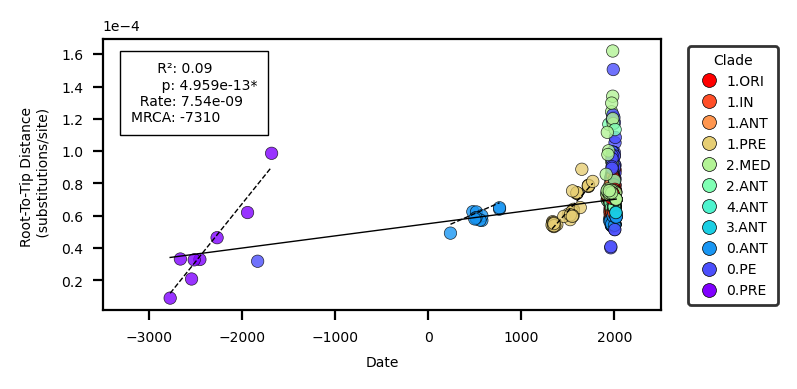

In [18]:
TARGET_RES = [720, 360]
DPI = 200
FIGSIZE = [TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE = 5
plt.rc("font", size=FONTSIZE)

                
dates = [float(date) for date in metadata_df["date_mean"]]
dists = [float(dist) for dist in metadata_df["root_rtt_dist"]]
dates_err = [float(date) for date in metadata_df["date_err"]]
color = [colors_dict[branch_major] for branch_major in metadata_df["branch_major"]]


p_sig = ""
if bootstrap_mega_dict["All"]["reject"]:
    p_sig = "*"
    
corrected_p_value = bootstrap_mega_dict["All"]["corrected_p_value"]
pretty_p_value = corrected_p_value
if pretty_p_value != 1:
    pretty_p_value = "{:.3e}".format(corrected_p_value)

fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI)
ax = axes

# plot regression line of clades with strict clock signal
for clade in bootstrap_mega_dict:
    # Distance of clade root to phylogeny root
    #print(bootstrap_mega_dict[clade]["samples"])
    clade_root_node =  divtree.common_ancestor(bootstrap_mega_dict[clade]["samples"])
    clade_root_dist = divtree.distance(clade_root_node)
    
    y_adjust = [y + clade_root_dist for y in bootstrap_mega_dict[clade]["y"]]
    
    linestyle = "--" if clade != "All" else "-"
    if bootstrap_mega_dict[clade]["reject"]:
        sns.regplot(
            ax=ax,
            x=bootstrap_mega_dict[clade]["x"],
            y=y_adjust,
            ci=None,
            scatter_kws={"s": 0},
            line_kws={"linewidth": 0.5, "zorder":10, "linestyle": linestyle},
            color="black",
        )

ax.scatter(
    x=dates,
    y=dists,
    s=20,
    color=color,
    ec="black",
    lw=0.25,
    label=None,
    alpha=0.8,
    zorder=3,
)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  
ax.set_xlim(-3500, 2500)
ax.set_xlabel("Date")
ax.set_ylabel("Root-To-Tip Distance \n (substitutions/site)", fontsize=5)

# Use the stats from bootstrapping!
ax.annotate(
    ("      R²: {}".format(round(bootstrap_mega_dict["All"]["r_squared"], 2))
        + "\n       p: {}{}".format(pretty_p_value, p_sig)
        + "\n  Rate: {:.2e}".format(bootstrap_mega_dict["All"]["slope"])
        + "\nMRCA: {:.0f}".format(bootstrap_mega_dict["All"]["x_intercept"])
    ),
    xy=(0.05, 0.8),
    xycoords="axes fraction",
    size=5,
    ha="left",
    va="center",
    bbox=dict(fc="w", lw=0.5),
)

# Clade legend
clades = list(colors_dict.keys())
clades.reverse()

clade_lines = [lines.Line2D([0], [0], color=colors_dict[clade], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for clade in clades]
clade_labels = [clade for clade in clades]

clade_legend = fig.legend(clade_lines, 
           clade_labels,
           #ncol=len(clade_labels),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(1, 0.5),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Clade",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
clade_legend.get_frame().set_linewidth(1)


out_path = os.path.join(out_dir, "rtt_all_branch_major")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

### Multiplot by Clade

Branch: 0.PRE
Branch: 0.PE
Branch: 0.ANT
Branch: 0.ANT4
Branch: 1.PRE
Branch: 1.ANT
Branch: 1.IN
Branch: 1.ORI
Branch: 2.ANT
Branch: 2.MED
Branch: 3.ANT
Branch: 4.ANT


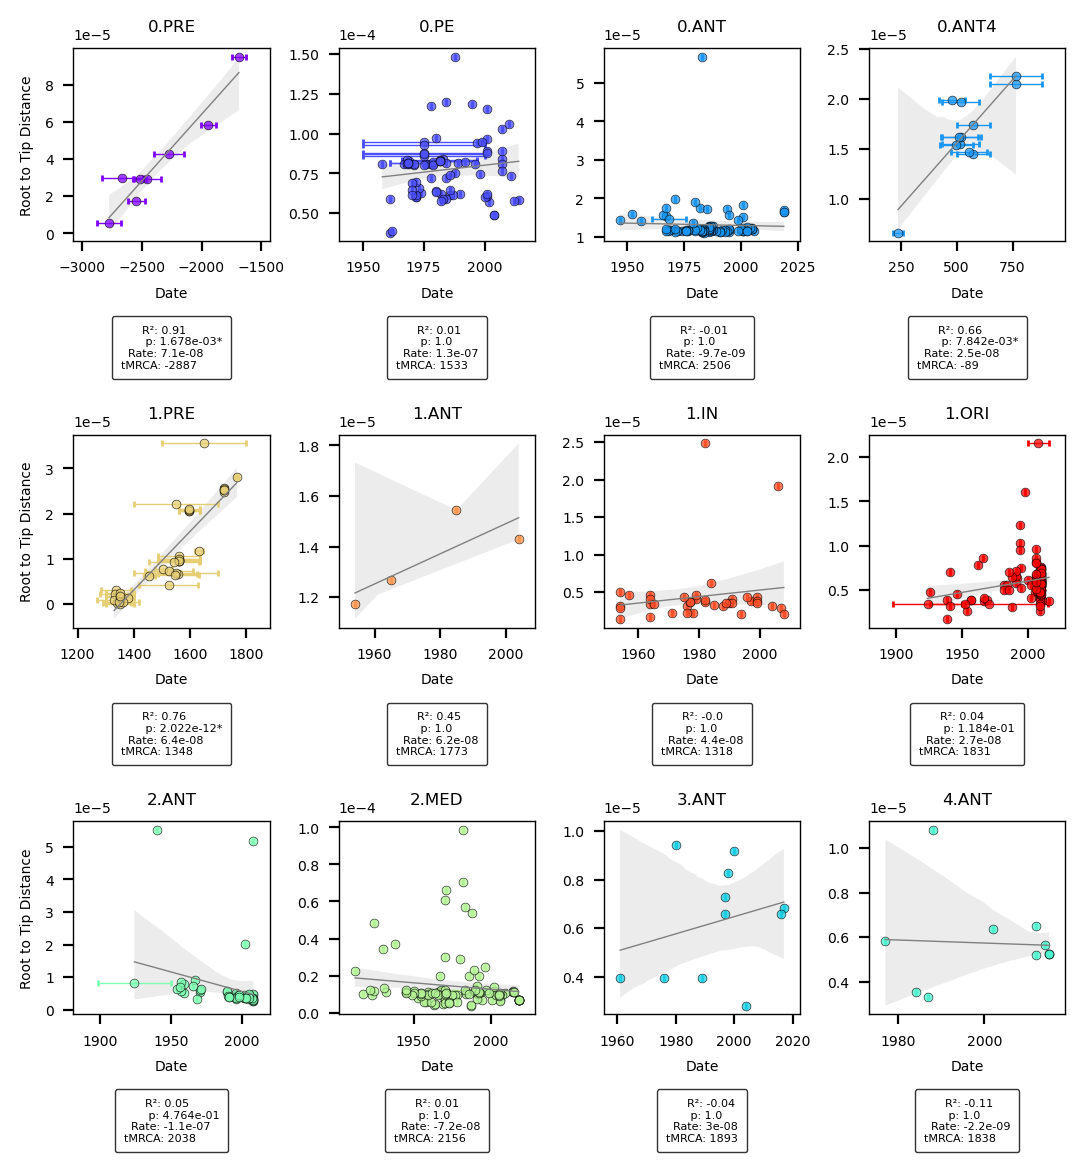

In [19]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280,  1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

reg_x = "date_mean"
reg_y = "clade_rtt_dist"
#reg_y = "root_rtt_dist"
reg_err = "date_err"

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=1)

i_row = 0
i_col = 0

for label in BRANCH_LIST:
    print("Branch:", label)
    
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]
    
    p_sig = ""
    if bootstrap_mega_dict[label]["reject"]:
        p_sig = "*"    
    corrected_p_value = bootstrap_mega_dict[label]["corrected_p_value"]
    pretty_p_value = corrected_p_value
    if pretty_p_value != 1:
        pretty_p_value = "{:.3e}".format(corrected_p_value)

    sns.regplot(
        ax=ax, 
        x=bootstrap_mega_dict[label]["x"],
        y=bootstrap_mega_dict[label]["y"], 
        ci=95,
        scatter_kws={"s": 0},
        line_kws={"linewidth" : 0.5},
        color="grey",
        label=(
        "      R²: {}".format(round(bootstrap_mega_dict[label]["r_squared"],2))
        + "\n       p: {}{}".format(pretty_p_value, p_sig)
        + "\n  Rate: {:.2}".format(bootstrap_mega_dict[label]["bootstrap_slope_peak"])  
        + "\ntMRCA: {}".format(round(bootstrap_mega_dict[label]["bootstrap_x_intercept_peak"]))                
        )
    )
    
    ax.errorbar(
        x=bootstrap_mega_dict[label]["x"],
        y=bootstrap_mega_dict[label]["y"], 
        xerr=bootstrap_mega_dict[label]["xerr"],       
        yerr=None,
        ls='none',
        color = bootstrap_mega_dict[label]["color"],  
        capsize=1,
        label=None,
        zorder=1,
        lw=0.5,
        )
    
    sns.scatterplot(
        ax=ax,
        x=bootstrap_mega_dict[label]["x"],
        y=bootstrap_mega_dict[label]["y"],  
        s=10,
        color = bootstrap_mega_dict[label]["color"], 
        ec = "black",
        alpha=0.75,
        zorder=2,
    )

    # Set xlimits
    xlim = ax.get_xlim()
    xrange = abs(xlim[1] - xlim[0])
    x_buff = xrange * 0.1
    new_xlim = [xlim[0] - x_buff, xlim[1] + x_buff]

    ax.set_xlim(new_xlim)

    ylim = ax.get_ylim()
    
    if ylim[0] < 0:
        ylim = ylim[0], ylim[1]
        
    yrange = abs(xlim[1] - xlim[0])
    y_buff = yrange * 0.1
    new_ylim = [ylim[0] - y_buff, ylim[1] + y_buff]

    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.55), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)
        
    # Format axis
    ax.set_title(label)

    if i_col == 0:
        ax.set_ylabel("Root to Tip Distance")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Date")    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1
    
out_path = os.path.join(out_dir, "rtt_regression_clades")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

### Rate

['All', '0.PRE', '0.PE', '0.ANT', '0.ANT4', '3.ANT', '4.ANT', '2.ANT', '2.MED', '1.PRE', '1.ANT', '1.IN', '1.ORI']
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/rate_boxplot_all


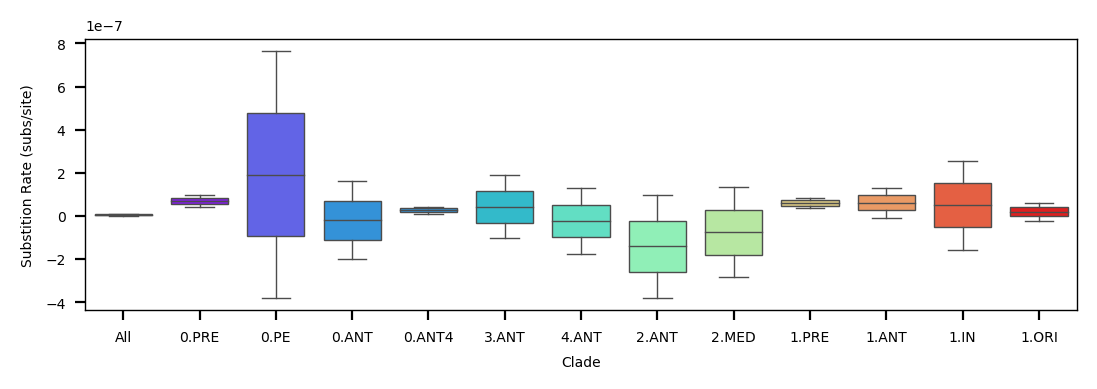

In [20]:
colors_dict_copy = copy.copy(colors_dict)
order = list(colors_dict_copy.keys())
order.insert(3, "0.ANT4")
order.insert(0, "All")
colors_dict_copy["0.ANT4"] = colors_dict["0.ANT"]
colors_dict_copy["All"] = "#c4c4c4"

violin_dict = {
    "label" : [],
    "rate" : [],
}

for label in bootstrap_mega_dict: 
    slope_kde = bootstrap_mega_dict[label]["bootstrap_slope_kde"]
    slope_ci = bootstrap_mega_dict[label]["bootstrap_slope_ci"]
    
    for rate in slope_kde.support: 
        violin_dict["label"].append(label)
        violin_dict["rate"].append(rate)    
        
        # Filter slopes within confidence interval          
        #if rate >= slope_ci[0] and rate <= slope_ci[1]:
        #    violin_dict["label"].append(label)
        #    violin_dict["rate"].append(rate)

# -------------------
# PLOT SETUP
TARGET_RES = [1280, 360]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
fig, axes = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)
            
ax = axes
for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.5)
ax.set_xlabel("Clade")
ax.set_ylabel("Substition Rate (subs/site)")

print(order)
sns.boxplot(
    ax=ax, 
    x=violin_dict["label"], 
    y=violin_dict["rate"], 
    #inner=None, 
    linewidth=0.50,
    width=0.75, 
    order=order,
    palette=colors_dict_copy,
)
  

out_path = os.path.join(out_dir, "rate_boxplot_all")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight", dpi=400)
plt.savefig(out_path + ".svg", bbox_inches="tight")

### tMRCA

['All', '0.PRE', '0.PE', '0.ANT', '0.ANT4', '3.ANT', '4.ANT', '2.ANT', '2.MED', '1.PRE', '1.ANT', '1.IN', '1.ORI']
/mnt/c/Users/ktmea/Projects/plague-phylogeography/results/iqtree/all/chromosome/full/filter5/filter-taxa/tmrca_boxplot_all


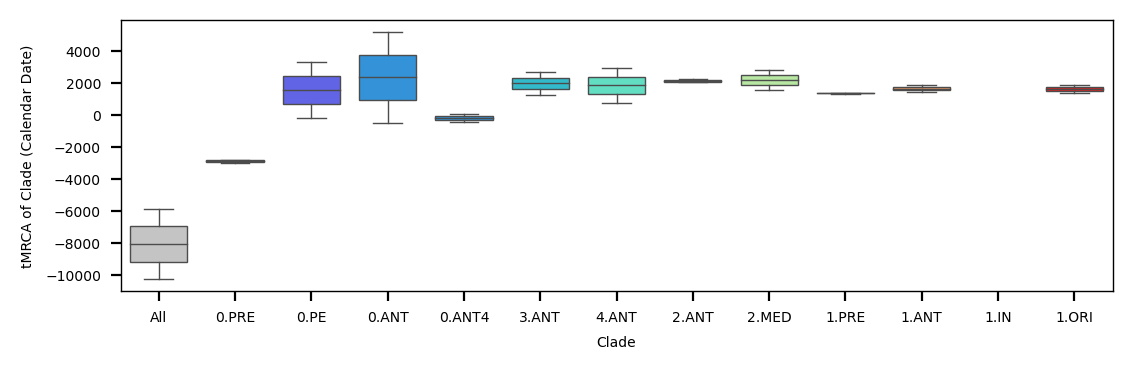

In [21]:
violin_dict = {
    "label" : [],
    "tmrca" : [],
}

for label in bootstrap_mega_dict: 
    tmrca_kde = bootstrap_mega_dict[label]["bootstrap_x_intercept_kde"]
    tmrca_ci = bootstrap_mega_dict[label]["bootstrap_x_intercept_ci"]
    
    for tmrca in tmrca_kde.support:
        
        #violin_dict["label"].append(label)
        #violin_dict["tmrca"].append(tmrca)
        
        # Filter slopes within confidence interval        
        if tmrca >= tmrca_ci[0] and tmrca <= tmrca_ci[1]:
            violin_dict["label"].append(label)
            violin_dict["tmrca"].append(tmrca)

# -------------------
# PLOT SETUP
TARGET_RES = [1280, 360]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
fig, axes = plt.subplots(1, dpi=DPI, figsize=FIGSIZE)
            
ax = axes
for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.5)
ax.set_xlabel("Clade")
ax.set_ylabel("tMRCA of Clade (Calendar Date)")

print(order)
sns.boxplot(
    ax=ax, 
    x=violin_dict["label"], 
    y=violin_dict["tmrca"], 
    #inner=None, 
    linewidth=0.50,
    width=0.75, 
    order=order,
    palette=colors_dict_copy,
)
  

out_path = os.path.join(out_dir, "tmrca_boxplot_all")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight", dpi=400)
plt.savefig(out_path + ".svg", bbox_inches="tight")

---

# 3. Geographic Structure

## All Distance Matrices

In [22]:
#NUM_SAMPLES = len(metadata_gdf.index)
NUM_SAMPLES = 200

gene_dist_mat = []
geo_dist_mat = []

all_dist_dict = {"gene":[],"geo":[], "mantel": {}}

i = 0
progress_size = 1
progress_next = 1

analysis_gdf = copy.deepcopy(metadata_gdf)

#for sample1 in metadata_gdf.index[:NUM_SAMPLES]:
for sample1 in analysis_gdf.index:
    progress = 100 * (i / len(analysis_gdf))
    if progress >= progress_next:
        print("{}%".format(round(progress,2)))
        progress_next += progress_size
    
    # Store distances in list for this sample
    geo_dist_list = []
    gene_dist_list = []
    
    geom1 = metadata_gdf["geometry"][sample1]
    coord1 = (geom1.y, geom1.x)     
    
    #for sample2 in metadata_gdf.index[:NUM_SAMPLES]:
    for sample2 in analysis_gdf.index:
        geom2 = metadata_gdf["geometry"][sample2]
        coord2 = (geom2.y, geom2.x)  

        # Calculate geographic and genetic distance
        geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 2)
        gene_dist = divtree.distance(sample1, sample2)   
        
        # Add to arrays
        geo_dist_list.append(geo_dist)
        gene_dist_list.append(gene_dist)   
        
    # Add to matrix
    all_dist_dict["geo"].append(geo_dist_list)
    all_dist_dict["gene"].append(gene_dist_list)
    
    # increment progress counter
    i += 1
    
print("100%")

# Check symmetry
"""arr1 = np.array(geo_dist_mat)
arr2 = np.array(geo_dist_mat).T

print(np.all(np.abs(arr1-arr2) < 1e-10))

# Check symmetry
arr1 = np.array(gene_dist_mat)
arr2 = np.array(gene_dist_mat).T

print(np.all(np.abs(arr1-arr2) < 1e-10))"""

coeff, p_value, n = skbio_dist.mantel(all_dist_dict["gene"], all_dist_dict["geo"])
all_dist_dict["mantel"]["coeff"] = coeff
all_dist_dict["mantel"]["p_value"] = p_value
all_dist_dict["mantel"]["n"] = n

print(all_dist_dict["mantel"])

1.16%
2.16%
3.16%
4.16%
5.16%
6.16%
7.15%
8.15%
9.15%
10.15%
11.15%
12.15%
13.14%
14.14%
15.14%
16.14%
17.14%
18.14%
19.13%
20.13%
21.13%
22.13%
23.13%
24.13%
25.12%
26.12%
27.12%
28.12%
29.12%
30.12%
31.11%
32.11%
33.11%
34.11%
35.11%
36.11%
37.1%
38.1%
39.1%
40.1%
41.1%
42.1%
43.09%
44.09%
45.09%
46.09%
47.09%
48.09%
49.08%
50.08%
51.08%
52.08%
53.08%
54.08%
55.07%
56.07%
57.07%
58.07%
59.07%
60.07%
61.06%
62.06%
63.06%
64.06%
65.06%
66.06%
67.05%
68.05%
69.05%
70.05%
71.05%
72.05%
73.04%
74.04%
75.04%
76.04%
77.04%
78.04%
79.03%
80.03%
81.03%
82.03%
83.03%
84.03%
85.02%
86.02%
87.02%
88.02%
89.02%
90.02%
91.01%
92.01%
93.01%
94.01%
95.01%
96.01%
97.0%
98.0%
99.0%
100%
{'coeff': -0.040925429548058, 'p_value': 0.145, 'n': 601}


## Clade Distance Matrices and Mantel Test

In [23]:
clade_dist_dict = {branch:{"gene":[],"geo":[], "mantel": {}} for branch in BRANCH_LIST}


for clade in BRANCH_LIST:
    print(clade)
    
    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[clade])]  
    
    for sample1 in df.index:
        
        # Store distances in list for this sample
        geo_dist_list = []
        gene_dist_list = []        
        
        geom1 = metadata_gdf["geometry"][sample1]
        coord1 = (geom1.y, geom1.x)  
    
        for sample2 in df.index:
            geom2 = metadata_gdf["geometry"][sample2]
            coord2 = (geom2.y, geom2.x)  
            
            # Calculate geographic and genetic distance
            geo_dist = round(geopy.distance.great_circle(coord1, coord2).km, 8)
            gene_dist = divtree.distance(sample1, sample2)   

            # Add to arrays
            geo_dist_list.append(geo_dist)
            gene_dist_list.append(gene_dist)   

        # Add to matrix
        clade_dist_dict[clade]["geo"].append(geo_dist_list)
        clade_dist_dict[clade]["gene"].append(gene_dist_list)  
        
    # Mantel Test
    coeff, p_value, n = skbio_dist.mantel(clade_dist_dict[clade]["gene"], clade_dist_dict[clade]["geo"])
    clade_dist_dict[clade]["mantel"]["coeff"] = coeff
    clade_dist_dict[clade]["mantel"]["p_value"] = p_value
    clade_dist_dict[clade]["mantel"]["n"] = n

0.PRE
0.PE
0.ANT
0.ANT4
1.PRE
1.ANT
1.IN
1.ORI
2.ANT
2.MED
3.ANT
4.ANT


## Correct P Values

In [24]:
# Correct p_values
raw_p_values = [clade_dist_dict[clade]["mantel"]["p_value"] for clade in clade_dist_dict]

# Add the p value from the all comparison to the end
raw_p_values += [all_dist_dict["mantel"]["p_value"]]

reject, corrected_p_values, alphacSidak, alphacBonf = smmt.multipletests(raw_p_values, alpha = 0.05, method = "holm")

i = 0
for clade in clade_dist_dict:
    clade_p_value = corrected_p_values[i]
    clade_reject = reject[i]
    clade_dist_dict[clade]["mantel"]["corrected_p_value"] = clade_p_value
    clade_dist_dict[clade]["mantel"]["reject"] = clade_reject
    i += 1
    
# The last corrected p_value is associated with all
all_p_value = corrected_p_values[i]
all_reject = reject[i]
all_dist_dict["mantel"]["corrected_p_value"] = all_p_value
all_dist_dict["mantel"]["reject"] = all_reject
    
# Save results to a file
out_path = os.path.join(out_dir, "mantel.tsv")

with open(out_path, "w") as outfile:
    headers = "{}\t{}\t{}\t{}\t{}\t{}".format(
        "clade",
        "coefficient",
        "raw_p_value",
        "n",
        "corrected_p_value",
        "reject",
    )
    outfile.write(headers + "\n")
    
    # All values
    data = ["all"] + list(all_dist_dict["mantel"].values())
    data_str = "\t".join([str(d) for d in data])
    outfile.write(data_str + "\n")
    
    # Clade Values
    for clade in clade_dist_dict:
        data = [clade] + list(clade_dist_dict[clade]["mantel"].values())
        data_str = "\t".join([str(d) for d in data])
        outfile.write(data_str + "\n")

## Plot Clades All in 1

4.ANT
3.ANT
2.MED
2.ANT
1.ORI
1.IN
1.ANT
1.PRE
0.ANT4
0.ANT
0.PE
0.PRE


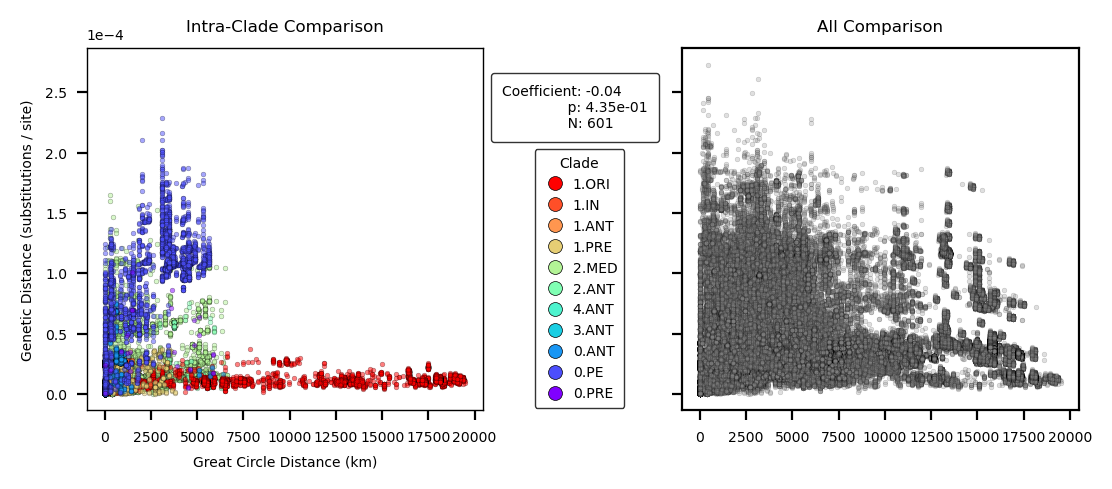

In [25]:
# PLOT SETUP
TARGET_RES = [1280, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)
fig, axes = plt.subplots(1,2,figsize=FIGSIZE, dpi=DPI, sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.50)

ax = axes[0]
for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.5)

ax.set_ylabel("Genetic Distance (substitutions / site)")
ax.set_xlabel("Great Circle Distance (km)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
ax.set_title("Intra-Clade Comparison")
    
# Plot by Clade

clades =list(BRANCH_LIST.keys())
clades.reverse()
for clade in clades:
    print(clade)
    
    # Color
    if clade == "0.ANT4":   
        color = colors_dict["0.ANT"]
    else:
        color = colors_dict[clade]
        
    # Extract the upper triangle of the distance matrices
    gene_dist_mat = np.array(clade_dist_dict[clade]["gene"])
    gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

    geo_dist_mat = np.array(clade_dist_dict[clade]["geo"])
    geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]

    # Add to the all plot
    sns.scatterplot(
        ax=ax,
        x=geo_dist_arr,
        y=gene_dist_arr,
        color=color,       
        s=3,
        ec = "black", 
        lw=0.1,
        alpha=0.50,
    )
    
# Dummy plot for label
p_sig = ""
if all_dist_dict["mantel"]["reject"]:
    p_sig = "*"
    
sns.scatterplot(
    ax=ax,
    x=[0],
    y=[0],
    s=0,
    label=(
        "Coefficient: {}".format(round(all_dist_dict["mantel"]["coeff"],2))
        + "\n               p: {:.2e}{}".format(all_dist_dict["mantel"]["corrected_p_value"],p_sig)             
        + "\n               N: {}".format(all_dist_dict["mantel"]["n"])          
        )          
)    


# Format and position legend
legend = ax.legend(
    borderpad=0.8, 
    handletextpad=-2, 
    edgecolor="black", 
    bbox_to_anchor=(1.46, 0.95), 
    #loc=1,
    fontsize=FONTSIZE,
)
frame = legend.get_frame().set_linewidth(0.5)     

# Clade legend
clades = list(colors_dict.keys())
clades.reverse()

clade_lines = [lines.Line2D([0], [0], color=colors_dict[clade], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="o") 
                for clade in clades]
clade_labels = [clade for clade in clades]

clade_legend = fig.legend(clade_lines, 
           clade_labels,
           #ncol=len(clade_labels),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.51, 0.40),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Clade",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
clade_legend.get_frame().set_linewidth(0.50)
   
    
ax = axes[1]
ax.set_title("All Comparison")
# Add to the all plot
# PLot all
gene_dist_mat = np.array(all_dist_dict["gene"])
gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

geo_dist_mat = np.array(all_dist_dict["geo"])
geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]
    
sns.scatterplot(
    ax=ax,
    x=geo_dist_arr,
    y=gene_dist_arr,
    color="grey",       
    s=3,
    ec = "black", 
    lw=0.1,
    alpha=0.25,
) 


out_path = os.path.join(out_dir, "mantel_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight") 

## Plot Clades Multi Plot

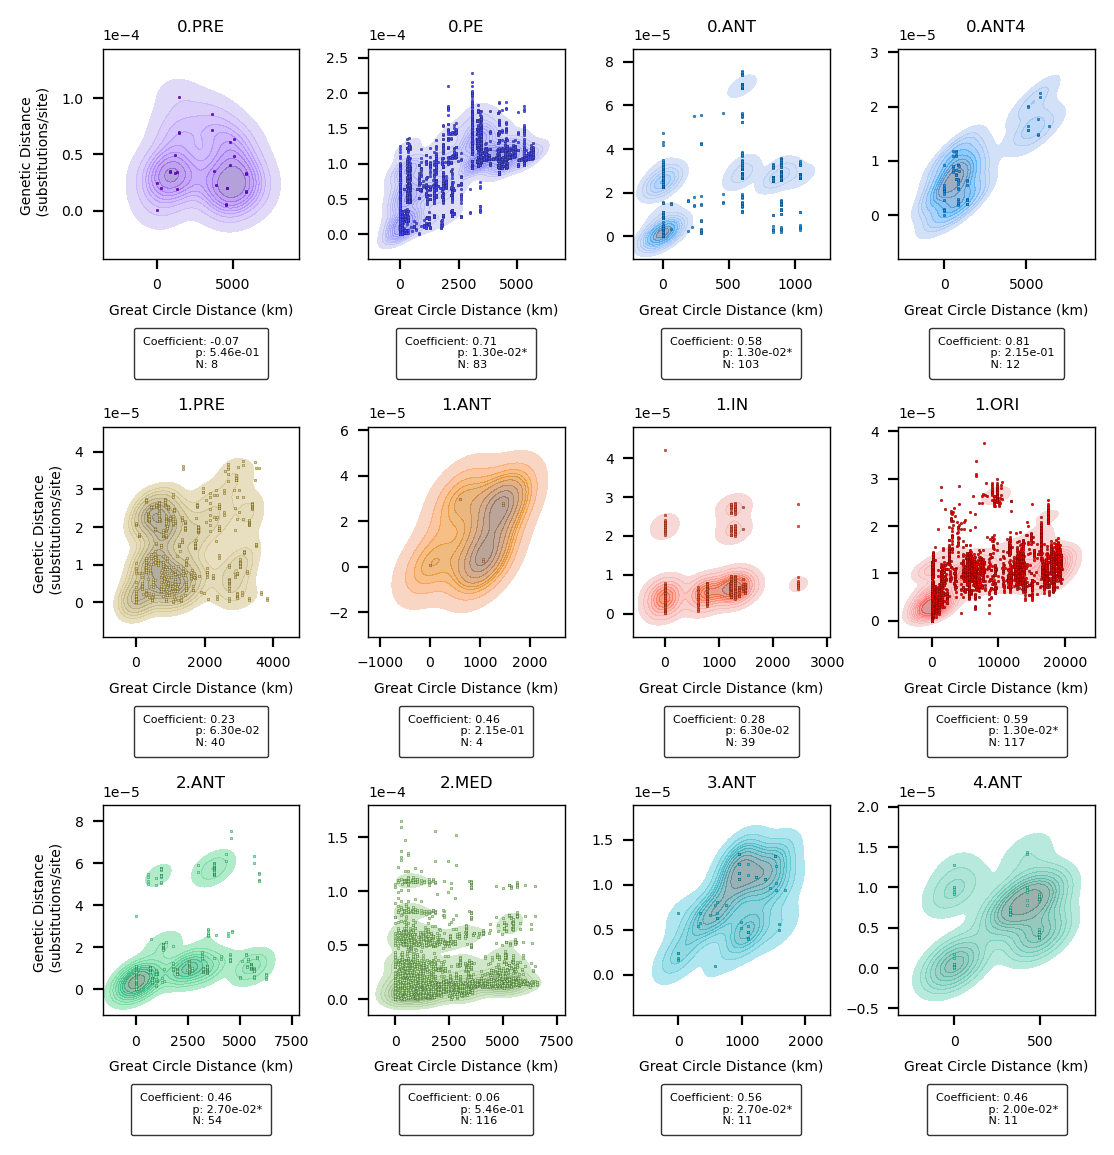

In [26]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.35, hspace=0.80)


i_row = 0
i_col = 0

for clade in BRANCH_LIST:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = metadata_gdf[metadata_gdf["branch_minor"].isin(BRANCH_LIST[clade])]  
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue  

    frame = legend.get_frame().set_linewidth(0.5)        
        
    # Format axis
    ax.set_title(clade)

    if i_col == 0:
        ax.set_ylabel("Genetic Distance \n (substitutions/site)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Great Circle Distance (km)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))    
    
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)  
        
    # Color
    if clade == "0.ANT4":   
        color = colors_dict["0.ANT"]
    else:
        color = colors_dict[clade]
        
    # Prepare data
    gene_dist_mat = np.array(clade_dist_dict[clade]["gene"])
    gene_dist_arr = gene_dist_mat[np.triu_indices(len(gene_dist_mat), k = 1)]

    geo_dist_mat = np.array(clade_dist_dict[clade]["geo"])
    geo_dist_arr = geo_dist_mat[np.triu_indices(len(geo_dist_mat), k = 1)]

    # Add scatter
    sns.scatterplot(
        ax=ax,
        x=geo_dist_arr,
        y=gene_dist_arr,
        color=color,       
        s=1,
        ec = "black",      
        alpha=1.00,
        zorder=2,      
    )
    
    sns.kdeplot(
        ax=ax,
        x=geo_dist_arr, 
        y=gene_dist_arr, 
        fill=True,
        zorder=1,
        color=color, 
        alpha=0.5,
        thresh=0.05,
    )
    
    # Dummy plot for label
    p_sig = ""
    if clade_dist_dict[clade]["mantel"]["reject"]:
        p_sig = "*"
    sns.scatterplot(
        ax=ax,
        x=[0],
        y=[0],
        s=0,
        label=(
            "Coefficient: {}".format(round(clade_dist_dict[clade]["mantel"]["coeff"],2))
            + "\n               p: {:.2e}{}".format(clade_dist_dict[clade]["mantel"]["corrected_p_value"],p_sig)      
        + "\n               N: {}".format(clade_dist_dict[clade]["mantel"]["n"])              
            )          
    )
    
    # Format and position legend
    legend = ax.legend(
        borderpad=0.8, 
        handletextpad=-2, 
        edgecolor="black", 
        bbox_to_anchor=(0.5, -0.45), 
        loc='center',
        fontsize=FONTSIZE * 0.80,
    )
    frame = legend.get_frame().set_linewidth(0.5)    
            

    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1 
    
    if label == "1.PRE":
        break
        
        
out_path = os.path.join(out_dir, "mantel_clades")
plt.savefig(out_path + ".png", bbox_inches="tight", dpi=400)
plt.savefig(out_path + ".svg", bbox_inches="tight") 

---

# 4. Timeline

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


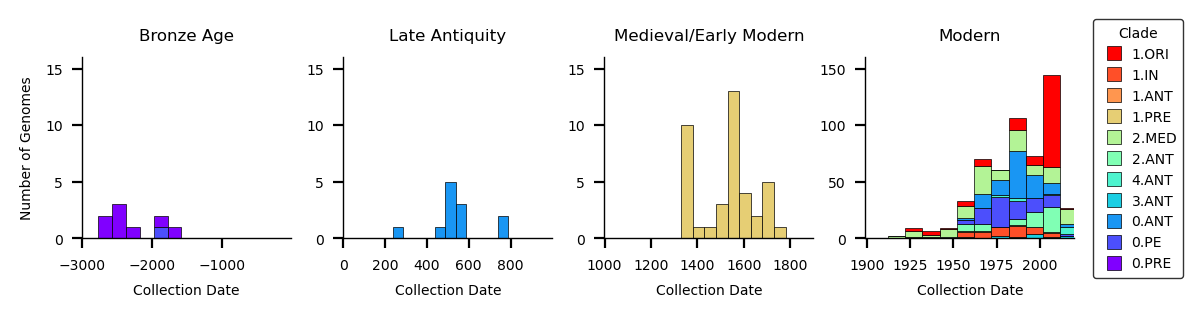

In [27]:
# PLOT SETUP
TARGET_RES = [1280, 240]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(1,4,figsize=FIGSIZE, dpi=DPI, sharey=False)
fig.subplots_adjust(wspace=0.25)

# Bronze Age
ax = axes[-4]
ax.set_title("Bronze Age")
ax_range = [-3001, -1]
ax.set_xlim(ax_range)
ax.set_ylim(0,16)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["branch_major"], 
    palette=colors_dict, 
    binwidth=200,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

# Roman
ax = axes[-3]
ax.set_title("Late Antiquity")
ax.set_ylim(0,16)

ax_range = [0, 999]
ax.set_xlim(ax_range)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["branch_major"], 
    palette=colors_dict, 
    binwidth=50,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()


# Medieval
ax = axes[-2]
ax.set_title("Medieval/Early Modern")
ax.set_ylim(0,16)
ax_range = [999, 1899]
ax.set_xlim(ax_range)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["branch_major"], 
    palette=colors_dict, 
    binwidth=50,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

# Modern
ax = axes[-1]
ax.set_title("Modern")
ax_range = [1899, 2020]
ax.set_xlim(ax_range)
ax.set_ylim(0,160)
df = metadata_gdf[(metadata_gdf["date_mean"] > ax_range[0]) & (metadata_gdf["date_mean"] <= ax_range[1]) ]
sns.histplot(
    ax=ax, 
    x=df["date_mean"], 
    multiple="stack",    
    hue=df["branch_major"], 
    palette=colors_dict, 
    binwidth=10,
    alpha=1.0,
    lw=0.25,
)
ax.legend().remove()

for ax in axes:
    ax.set_ylabel("")
    ax.set_xlabel("Collection Date")
axes[0].set_ylabel("Number of Genomes")

for ax in axes:
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)
    
# Clade legend
clades = list(colors_dict.keys())
clades.reverse()

clade_lines = [lines.Line2D([0], [0], color=colors_dict[clade], lw=0, markersize=5, markeredgecolor="black", markeredgewidth=0.25, marker="s") 
                for clade in clades]
clade_labels = [clade for clade in clades]

clade_legend = fig.legend(clade_lines, 
           clade_labels,
           #ncol=len(clade_labels),
           ncol=1,
           loc="center", 
           bbox_to_anchor=(0.95, 0.50),
           frameon=True,
           borderpad=0.5, 
           handletextpad=0.25, 
           labelspacing=0.5,
           edgecolor="black",
           title="Clade",
           fontsize=FONTSIZE,
           title_fontsize=FONTSIZE,
          )
clade_legend.get_frame().set_linewidth(0.50)
    
out_path = os.path.join(out_dir, "timeline_all")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

---

# Export

## Metadata

In [28]:
out_path_metadata = out_divtree_nwk_path = os.path.join(out_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)